In [24]:
from pyod.models.iforest import IForest
from sklearn.utils import shuffle
from pysad.evaluation import AUROCMetric
from pysad.models.integrations import ReferenceWindowModel
from pysad.utils import ArrayStreamer
from pysad.utils import Data
from tqdm import tqdm
import numpy as np
import pandas as pd

In [25]:
data = pd.read_csv("Data/Edu_TS_2_Traffic.csv", sep=";", parse_dates=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data.sort_values(by='Date', inplace=True)
iterator = ArrayStreamer(shuffle=False)

In [26]:
data_X = data['Unique Visitors'].values.reshape(-1, 1)  # Reshape to ensure 2D array
data_Y = None

In [27]:
model = ReferenceWindowModel(model_cls=IForest, window_size=24, sliding_size=3, initial_window_X=data_X[:10])
auroc = AUROCMetric()

In [28]:
# for X, y in tqdm(iterator.iter(data_X[10:], data_Y[10:])):

#     model.fit_partial(X)  # Fit to the instance.
#     score = model.score_partial(X)  # Score the instance.

#     auroc.update(y, score)  # Update the metric.

# # Output AUROC metric.
# print("AUROC: ", auroc.get())

----

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy.stats import f
import ruptures as rpt

# Default charting
rcParams['figure.figsize'] = 12,8
sns.set_theme()

In [30]:
data = pd.read_csv("Data/Edu_TS_2_Traffic.csv", sep=";", parse_dates=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data.set_index('Date', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)

### Stationary

In [31]:
adf_result = adfuller(data)
print(f'ADF Test Statistic {adf_result[0]:.2f}')
print(f'P Value {adf_result[1]:.2f}')
if adf_result[1] > 0.05:
    print('Time series is not stationary. Time-dependent structure such as seasonality exists.')
else:
    print('Time series is stationary, p value < 0.05.')

ADF Test Statistic -1.09
P Value 0.72
Time series is not stationary. Time-dependent structure such as seasonality exists.


### Seasonality

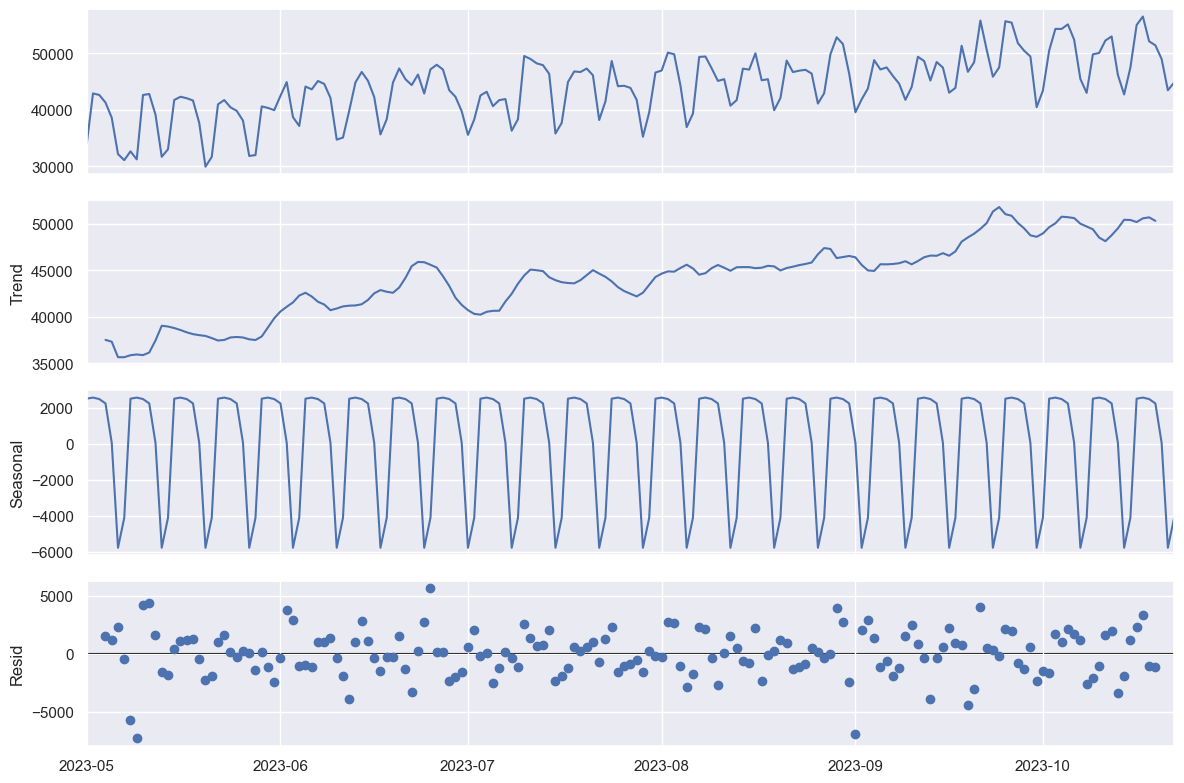

In [32]:
sd = seasonal_decompose(data)
sd.plot()
plt.show()

### Autocorrelation

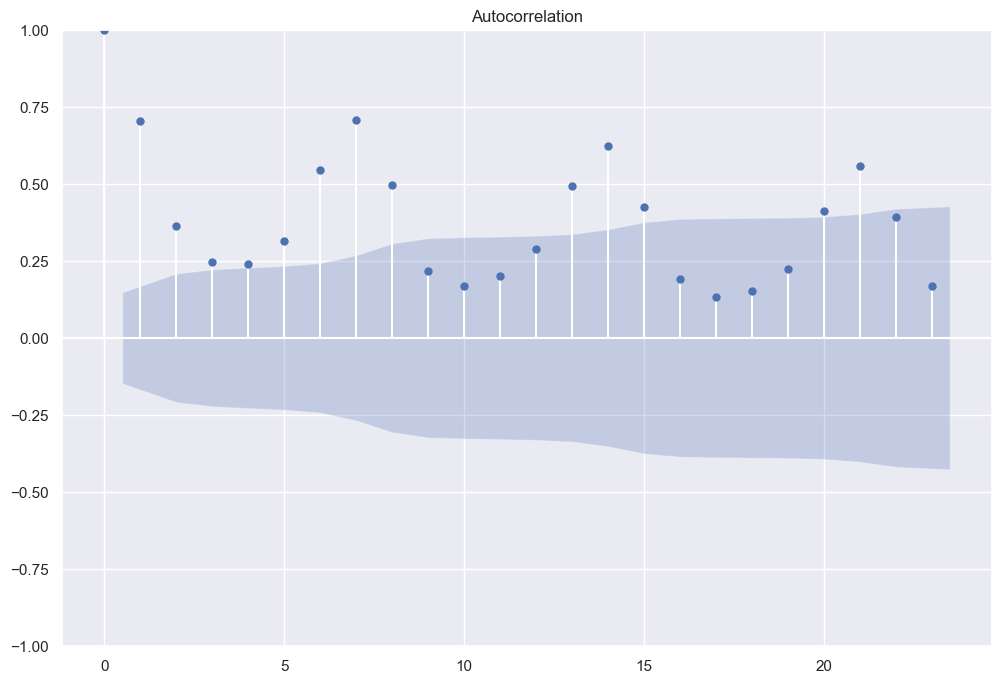

In [33]:
plot_acf(data)
plt.show()

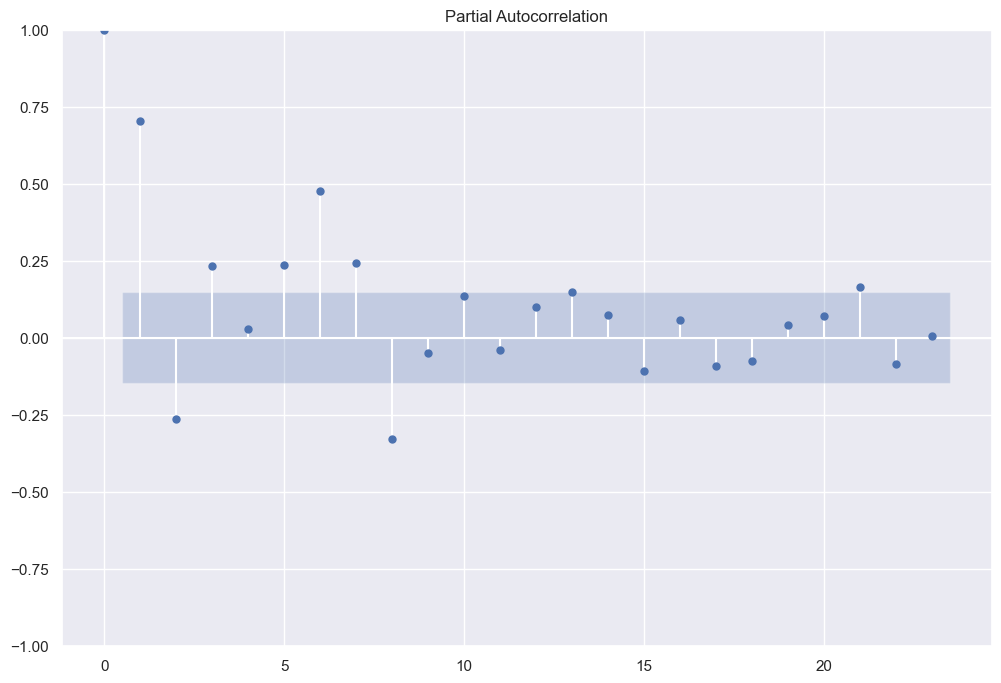

In [34]:
plot_pacf(data, method='ywm')
plt.show()

### Structural breaks

----

In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style('darkgrid')

<Axes: ylabel='Count'>

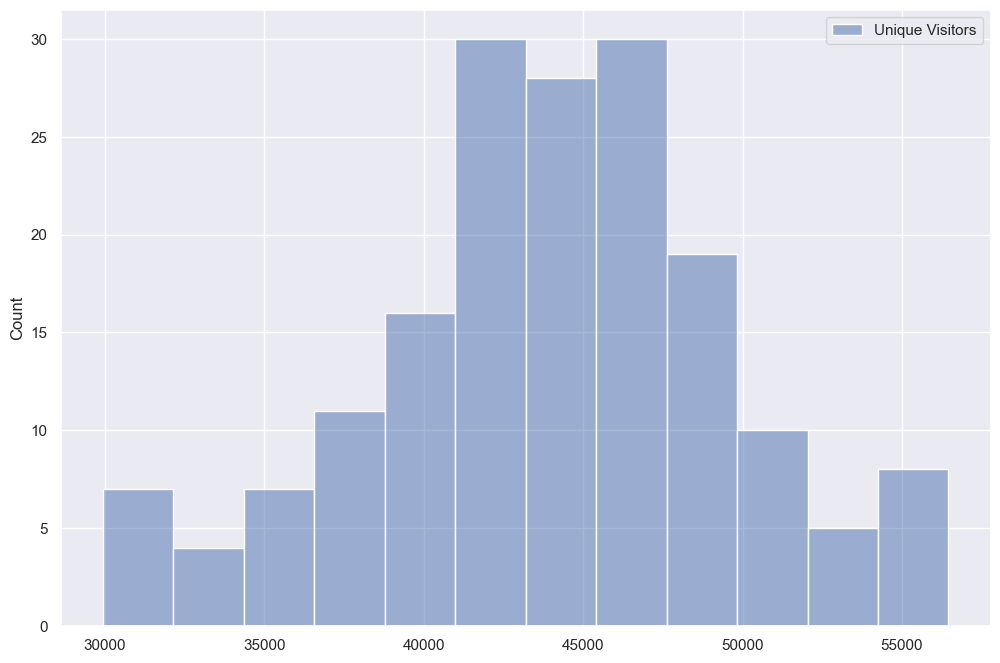

In [36]:
sns.histplot(data=data)

In [37]:
outlier_detection = IsolationForest(random_state=12)
outlier_detection.fit(data)

IsolationForest(random_state=12)

In [38]:
prediction = outlier_detection.predict(data)
prediction_strings = ['Outlier' if x < 0 else 'Standard' for x in prediction]

In [39]:
data['outlier_flag'] = prediction_strings

<Axes: xlabel='Date', ylabel='Unique Visitors'>

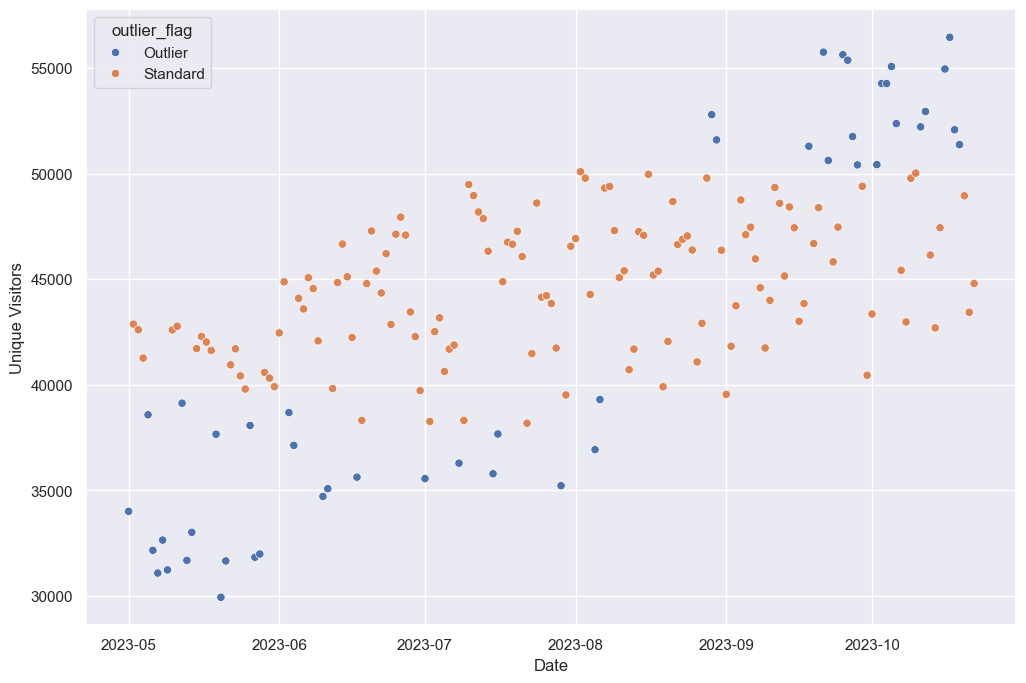

In [40]:
sns.scatterplot(data=data, y='Unique Visitors', hue='outlier_flag', x=data.index)

<Axes: xlabel='Date', ylabel='Unique Visitors'>

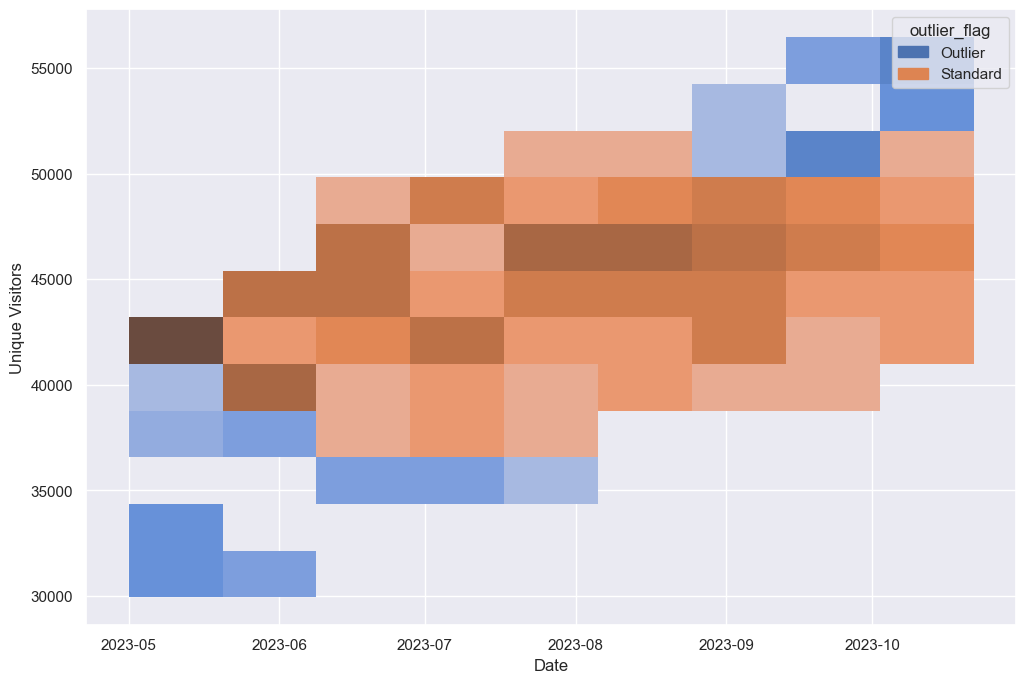

In [41]:
sns.histplot(data=data, y='Unique Visitors', hue='outlier_flag', x=data.index)

In [42]:
param_grid = {'n_estimators': list(range(100, 500, 50)), 
              'max_samples': ['auto', 0.25, 0.5, 0.75, 0.1], 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],  
              'bootstrap': [True, False]}

In [43]:
def custom_scorer(estimator, X):
    # Предположим, что мы хотим оценить количество обнаруженных аномалий
    predictions = estimator.predict(X)
    # Мы считаем, что аномалии обозначены как -1
    anomalies = predictions == -1
    # Возвращаем количество обнаруженных аномалий
    return anomalies.sum()

# Создаем скорер с помощью нашей функции оценки
custom_scorer = make_scorer(custom_scorer, greater_is_better=True)


In [44]:
grid_dt_estimator = model_selection.GridSearchCV(outlier_detection, 
                                                 param_grid,
                                                 scoring=custom_scorer, 
                                                 refit=True,
                                                 cv=5,
                                                 verbose=1,
                                                 n_jobs=5)

grid_dt_estimator.fit(data.loc[:, ['Unique Visitors']])

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


/Users/kosarenok/Developer/ts_outlier_detection/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kosarenok/Developer/ts_outlier_detection/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/kosarenok/Developer/ts_outlier_detection/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kosarenok/Developer/ts_outlier_detection/.venv/lib/python3.1

GridSearchCV(cv=5, estimator=IsolationForest(random_state=12), n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_samples': ['auto', 0.25, 0.5, 0.75, 0.1],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450]},
             scoring=make_scorer(custom_scorer, response_method='predict'),
             verbose=1)